# EDA Notebook

This data comes from IBM Business Analytics and it is comprised of 4 Databases with different amount of data from each customer like the services that were provided such as internet, cell, tv. As well as containing the demographics of each customer, the status and reason of churn with the data of revenue and payments. The goal of this notebook is to compile all the data and clean it so it is ready for the modeling and visualization steps. They are located in the [Modeling](Modeling_Notebook.ipynb) & [Visualizations](Visualizations_Notebook.ipynb) notebooks.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier


pd.set_option('display.max_columns', 100)

In [2]:
#loading dataframes
df1=pd.read_excel("Telco_customer_churn.xlsx")#contains general data of customers with payment information.
df2=pd.read_excel("Telco_customer_churn_status.xlsx")# contains information of why a customer left or not.
df3=pd.read_excel("Telco_customer_churn_services.xlsx")# contains information of services provided.
df4=pd.read_excel("Telco_customer_churn_demographics.xlsx")# contains demographics of each customer.

In [3]:
#Mergin dataframes into one
df1_2=pd.merge(df1, df2, left_on='CustomerID', right_on='Customer ID', how='left').drop('Customer ID', axis=1)
df3_4=pd.merge(df3, df4, left_on='Customer ID', right_on='Customer ID', how='left')
customer_df=pd.merge(df1_2, df3_4, left_on='CustomerID', right_on='Customer ID', how='left').drop('Customer ID', axis=1)

In [4]:
#Dropping duplicates from DF and renaming the columns 
customer_df=customer_df.T.drop_duplicates().T
customer_df.columns=[column.lower().strip("_x").strip("_y").replace(" ","_")for column in customer_df.columns] 

In [5]:
def remove_dups(lists):
    """
    Takes in a list of duplicated columns with the same name and removes the duplicated column and creates a
    new column with a new name and values assigned.
    Once that is complete it drops column from dataframe.
    """
    for i in range(len(lists)):
        customer_df["tel_"+lists[i]]=customer_df[lists[i]].iloc[:,1:2]
        customer_df.drop(lists[i],axis=1,inplace=True)

In [6]:
remove_dup=["internet_service","online_securit","online_backup","multiple_lines","streaming_tv","payment_method","total_charges","contract","streaming_movies","churn_reason"]

In [7]:
#Removing duplicates that were not caught by the previous function.
remove_dups(remove_dup)

In [8]:
#Dropping Redundant columns
customer_df.drop(["lat_long","customerid","churn_label","count","countr","state","quarter",],axis=1,inplace=True)

In [9]:
#Cleaning missing values from "total_charge" column
hold=[]
for x in customer_df.index:
    if type(customer_df.tel_total_charges[x])== str:
        hold.append(0)
    else:
        hold.append(customer_df.tel_total_charges[x])
customer_df.tel_total_chargs=hold

<ipython-input-9-3d09f234fd45>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  customer_df.tel_total_chargs=hold


In [10]:
#Binning age into gropus of 10 since its better to generalize.
customer_df.age=pd.cut(x=customer_df['age'], bins=[10,20,30,40, 50,60,70,80], labels=["10","20","30","40", "50","60","70"])

In [11]:
#Filling NA values for churn reason
customer_df.tel_churn_reason=customer_df.tel_churn_reason.fillna("No reason given")

Filling the column of Churn Category, by comparing if the customer churned or not. If the customer didnt churn, Fill it with "Not Churn" to add the category that the customer did not leave, therefore filling the missing valuees. If the customer left, then fill it with "No reason" since we dont have a reason of why they left.

In [12]:
conditions=[
    (customer_df["churn_categor"].isna())& (customer_df["churn_value"]==0),            
    (customer_df["churn_categor"].isna())& (customer_df["churn_value"]==1),
]
choises=[
    "Not Churned",
    "No Reason",

]
customer_df.churn_categor=np.select(conditions,choises,default=customer_df.churn_categor)

In [13]:
 def to_binary(column):
    """
    Takes in a column and turns its value from a Yes or No to a binary. 
    """
    conditions=[
        (customer_df[column].str.lower()=='yes'),            
        (customer_df[column].str.lower()=='no'),
    ]
    choises=[
        1,
        0,

    ]
    customer_df[column]=np.select(conditions,choises,default=0)

In [14]:
def reason_cleanup(column):
    """
    Takes in the tel_churn_reason column and creates its own main categories as to why a customer churned. 
    
    """    
    
    reasons={
        "Competition Offers":["Competitor had better devices","Competitor made better offer","Competitor offered more data","Competitor offered higher download speeds"],
        "Customer Satisfaction":["Attitude of support person","Attitude of service provider","Poor expertise of online support","Poor expertise of phone support"],
        "Pricing":["Price too high","Lack of affordable download/upload speed"],
        "Charges and Fees":["Long distance charges","Extra data charges"],
        "Product and Services":["Product dissatisfaction","Network reliability","Service dissatisfaction","Limited range of services","Lack of self-service on Website"],
        "External Factors":["Moved","Deceased"],
        "Unkown":["Don't know"],
        "Did Not Churn":["No reason given"]
    }
    reason=[]
    for i in customer_df[column].index:
        for key in reasons.keys():
            if customer_df[column][i]in reasons[key]:
                reason.append(key)
    return reason

In [15]:
# Re categorizing the churn reason for better interpretation.
customer_df["tel_churn_reason"]=reason_cleanup("tel_churn_reason")

In [16]:
#converting columns into binary
col_to_bin=["senior_citizen","partner","dependents","phone_service","device_protection","tech_support","paperless_billing","referred_a_friend","device_protection_plan","premium_tech_support","streaming_music","unlimited_data","under_30","tel_internet_service","tel_online_securit","tel_online_backup","tel_multiple_lines","tel_streaming_tv","tel_streaming_movies"]
for x in col_to_bin:
    to_binary(x)

In [17]:
#The clean Dataframe is saved to be used for Visualizations in the Visualizations notebook.
customer_df.to_csv("clean_customer_df.csv")

####  Preparing Dataframe for modeling. 

This part the categorical variables are made into dummies making sure to drop the first value. In the cleaning process, some features are not in the right format for modeling. I change the type of the DF to Float so all the data is able to be processed. 

In [18]:
# Columns portraing information of the target variable were dropped.
customer_df.drop(["tel_churn_reason","churn_categor","customer_status","churn_score"],axis=1, inplace=True)

In [19]:
# Columns with categorical information were transformed into dummy columns. 
customer_df=pd.get_dummies(customer_df,columns=["cit","zip_code","latitude","longitude","gender","offer","internet_type","age","tel_payment_method","tel_contract"],drop_first=True)

In [20]:
# Making sure that all data is able to be interpreted by models.
customer_df=customer_df.astype("float")

# Vanilla Model

For a Vanilla model, I want to explore a linear regression model. Since a Linear regression is the most basic and simple model to run without any parameter tuning. Logistic Regression is also useful for interpreting each feature's importance to the model and can set expectations for the modeling process. 

In [21]:
y=customer_df["churn_value"]
X=customer_df[customer_df.columns[customer_df.columns!="churn_value"]]

In [22]:
# keeping a random state to keep concistency on each model
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=2020, test_size=0.2)

In [23]:
# Scaling the data 
scaler=StandardScaler()
X_test=scaler.fit_transform(X_test)
X_train=scaler.transform(X_train)

In [24]:
# Fitting our model
lr=LogisticRegression(solver="sag" ,max_iter=1000, random_state=40, verbose=1, n_jobs=-1)

lr.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


convergence after 776 epochs took 222 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.7min finished


LogisticRegression(max_iter=1000, n_jobs=-1, random_state=40, solver='sag',
                   verbose=1)

In [25]:
print("Train Accuracy:",lr.score(X_train, y_train))

Train Accuracy: 0.9905928292509762
Test Accuracy: 0.8885734563520227


After scaling the data the model seems slightly overfit in the training dataset. The training set is close to being 1 and it can show that the model is adapting too well to the data provided and may need more bias to be introduced. 

In [26]:
y_pred_lr = lr.predict(X_test)

In [27]:
print('Logistic Regression Accuracy: {}'.format(metrics.accuracy_score(y_test, y_pred_lr)))
print('Logistic Regression F1: {}'.format(metrics.f1_score(y_test,y_pred_lr)))

Logistic Regression Accuracy: 0.8885734563520227
Logistic Regression F1: 0.7984595635430038


Comparing the Training score and the Testing score, the model is performing very well but the model is slightly overfit in the Training dataset and it may cause any future data provided to not be able to be predicted accurately. 

### RFE 

The data is very large and the vanilla model struggled to process data. I decided to use Recursive feature elimination to remove unnecessary data that is not highly correlated with the target variable. The goal of using RFE is to remove features that are just not helpful and mostly, to increase the fitting speed of future models. 

In [28]:
#creating RFE with cross validation for the best resulst.

rfc = RandomForestClassifier(random_state=2020, verbose=1, n_jobs=-1)
rfecv = RFECV(estimator=rfc, step=20, cv=StratifiedKFold(10), scoring='accuracy', verbose=1, n_jobs=-1, )
rfecv.fit(X, y)

Fitting estimator with 6132 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.4s finished


Fitting estimator with 6112 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished


Fitting estimator with 6092 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.6s finished


Fitting estimator with 6072 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished


Fitting estimator with 6052 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 6032 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 6012 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


Fitting estimator with 5992 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.2s finished


Fitting estimator with 5972 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 5952 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 5932 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


Fitting estimator with 5912 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


Fitting estimator with 5892 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 5872 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 5852 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 5832 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 5812 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Fitting estimator with 5792 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 5772 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Fitting estimator with 5752 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.0s finished


Fitting estimator with 5732 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


Fitting estimator with 5712 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Fitting estimator with 5692 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Fitting estimator with 5672 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Fitting estimator with 5652 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


Fitting estimator with 5632 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Fitting estimator with 5612 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


Fitting estimator with 5592 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 5572 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


Fitting estimator with 5552 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5532 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


Fitting estimator with 5512 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


Fitting estimator with 5492 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


Fitting estimator with 5472 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5452 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5432 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5412 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5392 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


Fitting estimator with 5372 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.8s finished


Fitting estimator with 5352 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5332 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5312 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5292 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5272 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5252 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


Fitting estimator with 5232 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5212 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5192 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5172 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    2.1s finished


Fitting estimator with 5152 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5132 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5112 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.7s finished


Fitting estimator with 5092 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 5072 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5052 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 5032 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 5012 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 4992 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 4972 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 4952 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 4932 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 4912 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 4892 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4872 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 4852 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4832 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4812 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 4792 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 4772 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4752 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4732 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4712 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4692 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4672 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4652 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4632 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 4612 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4592 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4572 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4552 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4532 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4512 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4492 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 4472 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4452 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


Fitting estimator with 4432 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.5s finished


Fitting estimator with 4412 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4392 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4372 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4352 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4332 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4312 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4292 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4272 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4252 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4232 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4212 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4192 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 4172 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 4152 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4132 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 4112 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 4092 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4072 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 4052 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.3s finished


Fitting estimator with 4032 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 4012 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3992 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3972 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3952 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3932 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3912 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3892 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3872 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3852 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


Fitting estimator with 3832 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3812 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3792 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3772 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3752 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3732 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3712 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3692 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3672 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3652 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.2s finished


Fitting estimator with 3632 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3612 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3592 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3572 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3552 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3532 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3512 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3492 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3472 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3452 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3432 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3412 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3392 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3372 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3352 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3332 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3312 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3292 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3272 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3252 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3232 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


Fitting estimator with 3212 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3192 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3172 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3152 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3132 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3112 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3092 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3072 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3052 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3032 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 3012 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 2992 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 2972 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 2952 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 2932 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 2912 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.0s finished


Fitting estimator with 2892 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2872 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2852 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2832 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2812 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2792 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2772 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2752 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2732 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2712 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2692 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2672 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2652 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2632 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2612 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished


Fitting estimator with 2592 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2572 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


Fitting estimator with 2552 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2532 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2512 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


Fitting estimator with 2492 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2472 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2452 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


Fitting estimator with 2432 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2412 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2392 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2372 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2352 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


Fitting estimator with 2332 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2312 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2292 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2272 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2252 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2232 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2212 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2192 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2172 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2152 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2132 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2112 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2092 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2072 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2052 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2032 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 2012 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1992 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1972 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1952 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1932 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1912 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1892 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1872 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1852 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1832 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1812 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1792 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1772 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1752 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1732 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1712 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1692 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1672 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1652 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1632 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1612 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1592 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1572 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1552 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1532 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1512 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1492 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1472 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1452 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1432 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1412 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1392 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1372 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1352 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1332 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1312 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1292 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1272 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1252 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1232 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1212 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1192 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1172 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1152 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1132 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1112 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1092 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1072 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1052 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1032 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 1012 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 992 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 972 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 952 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 932 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 912 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 892 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 872 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 852 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 832 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 812 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 792 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 772 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 752 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 732 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 712 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 692 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 672 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 652 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 632 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 612 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 592 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 572 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 552 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 532 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 512 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 492 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 472 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 452 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


Fitting estimator with 432 features.


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Fitting estimator with 412 features.


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 392 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 372 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 352 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 332 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 312 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 292 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 272 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 252 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 232 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 212 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 192 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 172 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 152 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s


Fitting estimator with 132 features.


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(n_jobs=-1, random_state=2020, verbose=1),
      n_jobs=-1, scoring='accuracy', step=20, verbose=1)

In [29]:
# Dropping the columns that RFE deems not relevant.
X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In this graph we can visualize the amount of features that were eliminated with each score achieved after each elimination.

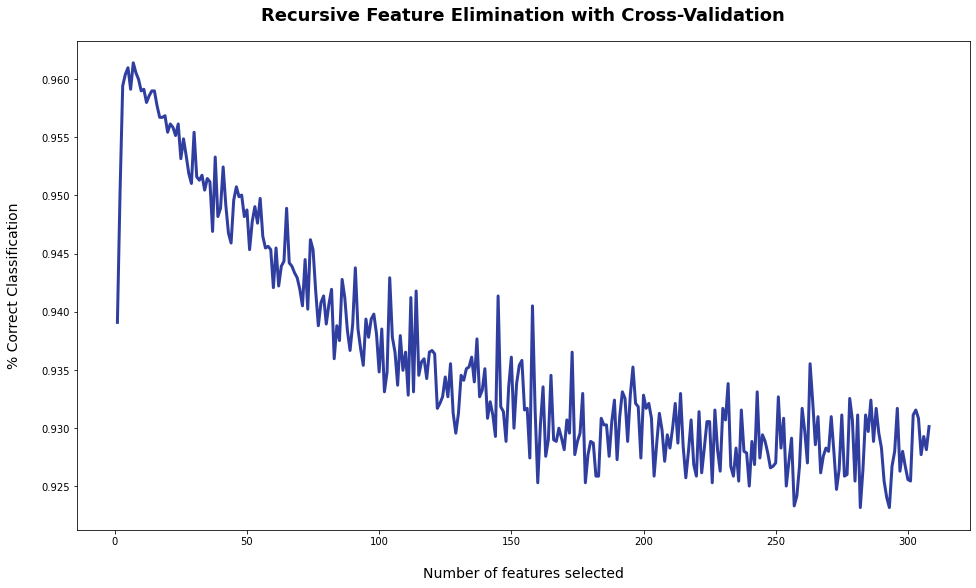

In [30]:
#Plotting the scores and number of features RFE used.
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)
plt.show()

In [31]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 112


As we can see, the best number of features the model chose is 112. This shows, as the graph presents above, the best scores ranged between .94 and .95 which is something that we want to keep throughout our modeling process.

In [32]:
model_df=X.copy()
model_df["y"]=y
model_df.to_csv("modeling_customer_df.csv")